Import Libraries and supporting file

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from glob import glob
import utils
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
profile_dataframe = pd.read_csv('./Dataset/vip/annotation.csv')
profile_dataframe.head()
print(len(profile_dataframe))

1026


In [3]:
all_files = glob("./Dataset/vip/data/*")
all_jpgs = sorted([img for img in all_files if ".jpg" in img or ".jpeg" in img or "JPG" in img])
print("Total {} photos ".format(len(all_jpgs)))

Total 1026 photos 


In [4]:
id_path = [image for image in all_jpgs ]
image_dataframe = pd.DataFrame(id_path, columns=['path'])

In [5]:
data_dataframe = image_dataframe.merge(profile_dataframe, left_index=True, right_index=True)
data_dataframe.head()

,path,image,height,weight,BMI
0,./Dataset/vip/data/f_001.jpg,f_001,1.55,61.0,25.390219
1,./Dataset/vip/data/f_002.jpg,f_002,1.76,85.0,27.440599
2,./Dataset/vip/data/f_003.jpg,f_003,1.78,56.0,17.674536
3,./Dataset/vip/data/f_004.jpg,f_004,1.63,63.0,23.711845
4,./Dataset/vip/data/f_005.jpg,f_005,1.76,54.0,17.432851


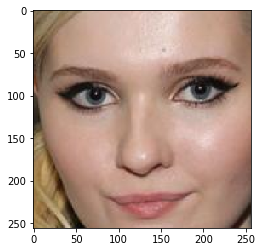

In [6]:
# Preview encoding function
original_image = cv2.imread(data_dataframe.iloc[0].path)
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')
detected_faces = face_cascade.detectMultiScale(grayscale_image)
_ = plt.imshow(grayscale_image, cmap='gray')
dim = (256, 256)
for (column, row, width, height) in detected_faces:
    crop_image = original_image[column: (column + width), row : (row + height)]
    # resize image
    resized = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA)

# For testing
resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
_ = plt.imshow(resized)

In [7]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')
def get_face_encoding(image_path):
    original_image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    crop_image = []
    for (column, row, width, height) in detected_faces:
        crop_image = original_image[column: (column + width), row : (row + height)]
    return crop_image

In [8]:
# from PIL import Image
all_faces = []
for image_path in data_dataframe.path:
    face = get_face_encoding(image_path))
    flat_face = [item for channel in face for item in channel]
    all_faces.append(face)
X = np.array(all_faces)
print(X.shape)
print(X[0].shape)

(1026,)
(83667,)


In [39]:
import itertools
face = get_face_encoding(data_dataframe.path[0])
flat_face = np.array(list(itertools.chain(*face)))
print(face.shape)
print(flat_face.shape)

(167, 167, 3)
(27889, 3)


In [46]:
# Loading pretrained model from Pytorch for using deep learning
# from torchvision import models
# resnet = models.resnet50()
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize(256), #resize input to 256x256
#     transforms.CenterCrop(224), #crop the image 224x224 pixels about the center
#     transforms.ToTensor(), #convert to tensor
#     transforms.Normalize( #normalization the tensor
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.226, 0.225]
#     )
# ])
# final_layer = nn.Linear(2048, 1)
# resnet.fc = final_layer
# print(resnet)

In [10]:
from sklearn.model_selection import train_test_split
y_height = np.array(data_dataframe.height.values)
y_weight = data_dataframe.weight.values
y_BMI = data_dataframe.BMI.values
X_train, X_test, y_height_train, y_height_test, y_weight_train, y_weight_test ,y_BMI_train, y_BMI_test = train_test_split(X, y_height,y_weight,y_BMI, random_state=1)

In [11]:
from sklearn.kernel_ridge import KernelRidge
from sklearn import  linear_model
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def report_goodness(model,X_test,y_test,predictor_log=True):
    # Make predictions using the testing set
    y_pred = model.predict(X_test)
    y_true = y_test
    if predictor_log:
        y_true = np.log(y_test)
    # The coefficients
    # The mean squared error
    print("Mean squared error: %.2f"% mean_squared_error(y_true, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_true, y_pred))
    
    errors = abs(y_pred - y_true)
    mape = 100 * np.mean(errors / y_true)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [12]:
print(X_train[:2])
print(y_height_train[:2])
print(X_train.shape)

[array([ 0,  9, 27, ..., 51, 56, 65], dtype=uint8)
 array([ 6, 11, 14, ...,  3, 16, 32], dtype=uint8)]
[1.88 1.68]
(769,)


In [30]:
print(y_height_train.ndim)
print(X_train.ndim)

1
1


In [28]:

my_X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
my_y = np.dot(my_X, np.array([1, 2])) + 3
reg = linear_model.LinearRegression().fit(my_X, my_y)
print(my_X.shape)
print(my_y.shape)

(4, 2)
(4,)


In [20]:
#Simple linear regression
model_height = linear_model.LinearRegression()
model_height = model_height.fit(list(X_train), list(np.log(y_height_train)))
report_goodness(model_height, X_test, y_height_test)

ValueError: Expected 2D array, got 1D array instead:
array=[array([ 0,  9, 27, ..., 51, 56, 65], dtype=uint8)
 array([ 6, 11, 14, ...,  3, 16, 32], dtype=uint8)
 array([ 85, 127, 169, ...,  51,  87, 141], dtype=uint8)
 array([178, 191, 189, ..., 130, 136, 135], dtype=uint8)
 array([122, 138, 145, ..., 104, 125, 147], dtype=uint8)
 array([ 23,  29,  42, ..., 206, 201, 200], dtype=uint8)
 array([31, 31, 31, ..., 79, 77, 76], dtype=uint8)
 array([55, 66, 86, ..., 24, 40, 53], dtype=uint8)
 array([17, 22, 31, ..., 21, 27, 46], dtype=uint8)
 array([ 76,  87, 115, ...,  72,  67,  99], dtype=uint8)
 array([79, 84, 83, ..., 37, 39, 40], dtype=uint8)
 array([  8,   8,   8, ...,  49,  86, 136], dtype=uint8)
 array([ 12,  16,  21, ..., 184, 186, 187], dtype=uint8)
 array([ 26,  37,  75, ..., 203, 207, 208], dtype=uint8)
 array([ 46,  48,  58, ..., 255, 255, 255], dtype=uint8)
 array([ 28,  24,  23, ..., 147, 138, 134], dtype=uint8)
 array([142, 166, 190, ..., 115, 144, 183], dtype=uint8)
 array([ 45,  47,  48, ..., 210, 205, 204], dtype=uint8)
 array([103, 110, 127, ..., 153, 162, 171], dtype=uint8)
 array([ 8, 10, 10, ...,  0,  0,  0], dtype=uint8)
 array([ 65,  89, 101, ...,   7,   9,  10], dtype=uint8)
 array([ 33,  37,  42, ...,  83, 103, 161], dtype=uint8)
 array([100, 105, 126, ..., 255, 255, 255], dtype=uint8)
 array([149, 179, 206, ..., 101, 149, 197], dtype=uint8)
 array([196, 186, 169, ...,  34,  31,  26], dtype=uint8)
 array([ 5, 16, 30, ..., 11, 19, 36], dtype=uint8)
 array([ 97, 138, 183, ...,  98, 135, 187], dtype=uint8)
 array([ 91, 120, 151, ..., 133, 162, 189], dtype=uint8)
 array([ 25,  34,  44, ..., 154, 171, 192], dtype=uint8)
 array([ 34,  44,  54, ..., 241, 249, 248], dtype=uint8)
 array([205, 213, 213, ...,  73,  96, 128], dtype=uint8)
 array([ 26,  25,  35, ...,  41,  55, 137], dtype=uint8)
 array([129, 146, 173, ...,  81, 113, 148], dtype=uint8)
 array([ 95, 116, 138, ...,   0,   0,   0], dtype=uint8)
 array([ 35,  45,  62, ..., 106, 127, 165], dtype=uint8)
 array([112, 128, 157, ..., 102, 124, 176], dtype=uint8)
 array([ 7, 16, 20, ..., 16, 30, 58], dtype=uint8)
 array([246, 247, 245, ...,  72,  98, 134], dtype=uint8)
 array([ 23,  35, 167, ...,   5,   4,   6], dtype=uint8)
 array([167, 189, 207, ..., 178, 202, 224], dtype=uint8)
 array([], dtype=float64)
 array([ 43,  55,  79, ...,  88, 102, 124], dtype=uint8)
 array([128, 137, 146, ..., 136, 153, 180], dtype=uint8)
 array([15, 20, 35, ..., 43, 43, 43], dtype=uint8)
 array([191, 196, 199, ..., 121, 154, 180], dtype=uint8)
 array([ 18,  21,  29, ...,  77,  80, 108], dtype=uint8)
 array([ 3, 10, 29, ..., 14, 33, 60], dtype=uint8)
 array([ 67,  69, 133, ...,  92,  94, 148], dtype=uint8)
 array([ 20,  17,  19, ..., 154, 148, 149], dtype=uint8)
 array([ 65,  70,  91, ..., 190, 195, 193], dtype=uint8)
 array([ 97, 125,  95, ..., 106, 110,  99], dtype=uint8)
 array([255, 252, 248, ..., 241, 239, 238], dtype=uint8)
 array([ 10,  12,  22, ..., 196, 209, 217], dtype=uint8)
 array([ 11,  11,  11, ..., 166, 174, 197], dtype=uint8)
 array([ 75,  78,  92, ..., 146, 160, 182], dtype=uint8)
 array([106, 121, 130, ...,   0,   0,   0], dtype=uint8)
 array([137, 167, 196, ..., 142, 179, 205], dtype=uint8)
 array([ 97, 117, 172, ..., 109, 187, 230], dtype=uint8)
 array([ 38,  52,  75, ..., 126, 128, 139], dtype=uint8)
 array([131, 122, 108, ..., 122, 128, 133], dtype=uint8)
 array([26, 28, 39, ...,  0,  0,  0], dtype=uint8)
 array([ 79,  96, 105, ...,  26,  28,  22], dtype=uint8)
 array([ 62,  71,  85, ...,  71,  82, 109], dtype=uint8)
 array([ 20,  24,  25, ...,  75,  98, 143], dtype=uint8)
 array([ 63,  82,  87, ..., 108, 156, 158], dtype=uint8)
 array([130, 153, 179, ...,  63,  70,  97], dtype=uint8)
 array([169, 177, 176, ..., 147, 168, 200], dtype=uint8)
 array([28, 25, 27, ..., 46,  8,  4], dtype=uint8)
 array([69, 71, 72, ..., 28, 20, 13], dtype=uint8)
 array([ 47,  56,  60, ...,  79, 100, 145], dtype=uint8)
 array([ 93, 123, 180, ...,  54,  73, 106], dtype=uint8)
 array([16, 15, 31, ...,  3,  4, 14], dtype=uint8)
 array([ 54,  81, 132, ...,  85, 109, 145], dtype=uint8)
 array([153, 173, 190, ...,  46,  56,  74], dtype=uint8)
 array([108, 128, 146, ..., 205, 221, 227], dtype=uint8)
 array([34, 52, 63, ..., 45, 50, 51], dtype=uint8)
 array([ 11,  23,  27, ..., 233, 237, 238], dtype=uint8)
 array([217, 216, 218, ...,  70,  64,  99], dtype=uint8)
 array([129, 160, 183, ...,  15,  19,  24], dtype=uint8)
 array([ 69,  97, 132, ..., 128, 156, 187], dtype=uint8)
 array([158, 191, 230, ..., 112, 144, 179], dtype=uint8)
 array([181, 202, 223, ..., 127, 171, 235], dtype=uint8)
 array([ 50,  51,  65, ..., 255, 255, 255], dtype=uint8)
 array([34, 42, 55, ...,  1,  7, 12], dtype=uint8)
 array([38, 42, 47, ..., 22, 41, 76], dtype=uint8)
 array([ 66,  80, 102, ..., 187, 190, 194], dtype=uint8)
 array([  0,   1,   5, ..., 213, 213, 213], dtype=uint8)
 array([ 68,  94, 110, ...,  90, 101, 115], dtype=uint8)
 array([51, 55, 60, ...,  9, 14, 13], dtype=uint8)
 array([107, 141, 171, ..., 112, 144, 187], dtype=uint8)
 array([ 2, 17, 43, ...,  0,  0,  7], dtype=uint8)
 array([ 89,  83, 130, ..., 151, 165, 187], dtype=uint8)
 array([ 52,  81, 126, ...,  48,  66, 107], dtype=uint8)
 array([ 87, 116, 160, ...,   1,   5,  34], dtype=uint8)
 array([ 30,  57,  84, ..., 254, 254, 254], dtype=uint8)
 array([ 19,  21,  22, ..., 193, 196, 201], dtype=uint8)
 array([ 98, 120, 156, ...,  51,  59,  49], dtype=uint8)
 array([2, 4, 5, ..., 3, 2, 4], dtype=uint8)
 array([ 97,  99, 109, ..., 164, 176, 194], dtype=uint8)
 array([ 67, 102, 158, ..., 147, 167, 214], dtype=uint8)
 array([  3,  10,  29, ..., 158, 211, 238], dtype=uint8)
 array([ 63,  80, 101, ...,  38,  44,  63], dtype=uint8)
 array([109, 147, 182, ...,  98, 120, 168], dtype=uint8)
 array([ 44,  49,  82, ..., 105, 141, 187], dtype=uint8)
 array([ 71,  85, 113, ...,  24,  40,  63], dtype=uint8)
 array([ 8,  7,  9, ..., 33, 56, 88], dtype=uint8)
 array([], dtype=float64)
 array([165, 151, 133, ...,  10,  19,  86], dtype=uint8)
 array([ 77,  96, 129, ...,  43,  71, 102], dtype=uint8)
 array([ 16,  18,  26, ..., 218, 227, 230], dtype=uint8)
 array([111, 133, 174, ...,   1,   3,  13], dtype=uint8)
 array([ 98, 160, 220, ...,   1,   1,   1], dtype=uint8)
 array([216, 223, 226, ..., 172, 172, 178], dtype=uint8)
 array([ 42,  48,  55, ..., 236, 232, 227], dtype=uint8)
 array([ 70,  75,  84, ...,  62,  88, 148], dtype=uint8)
 array([ 3,  2, 68, ...,  0,  0,  7], dtype=uint8)
 array([  3,  20,  63, ..., 116, 161, 195], dtype=uint8)
 array([ 61,  72, 104, ..., 102, 164, 174], dtype=uint8)
 array([ 17,  17,  17, ..., 176, 165, 161], dtype=uint8)
 array([  6,  28,  64, ..., 182, 186, 197], dtype=uint8)
 array([29, 36, 39, ..., 14, 12, 12], dtype=uint8)
 array([66, 75, 72, ..., 23, 37, 35], dtype=uint8)
 array([ 82,  97, 113, ..., 191, 191, 197], dtype=uint8)
 array([20, 14, 37, ..., 29, 29, 75], dtype=uint8)
 array([83, 76, 79, ..., 41, 56, 72], dtype=uint8)
 array([ 66,  98, 127, ...,  71,  91, 109], dtype=uint8)
 array([ 68, 110, 145, ...,  32,  44,  62], dtype=uint8)
 array([30, 36, 35, ..., 31, 33, 41], dtype=uint8)
 array([125, 155, 196, ..., 158, 191, 217], dtype=uint8)
 array([29, 34, 43, ..., 45, 66, 98], dtype=uint8)
 array([], dtype=float64)
 array([ 17,  40,  66, ..., 112, 153, 185], dtype=uint8)
 array([], dtype=float64)
 array([ 19,  22,  30, ..., 126, 149, 195], dtype=uint8)
 array([134, 167, 216, ...,  46,  52,  87], dtype=uint8)
 array([ 59,  28,  27, ..., 142,  94, 182], dtype=uint8)
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)
 array([  0,   6,   9, ..., 140, 121, 116], dtype=uint8)
 array([ 33,  42,  75, ...,  69,  93, 153], dtype=uint8)
 array([ 57, 100, 139, ...,  28,  41,  63], dtype=uint8)
 array([ 38,  63,  95, ..., 203, 214, 228], dtype=uint8)
 array([ 11,  16,  15, ..., 134, 108,  94], dtype=uint8)
 array([44, 41, 43, ..., 17, 20, 24], dtype=uint8)
 array([ 34, 102, 149, ...,  45,  49,  67], dtype=uint8)
 array([ 6, 11, 14, ...,  5,  5,  5], dtype=uint8)
 array([29, 48, 55, ..., 19, 21, 22], dtype=uint8)
 array([ 0,  0,  4, ..., 37, 49, 89], dtype=uint8)
 array([ 14,  25,  33, ...,  97, 104, 123], dtype=uint8)
 array([ 19,  28,  38, ...,  71,  84, 106], dtype=uint8)
 array([30, 36, 59, ...,  0, 26, 83], dtype=uint8)
 array([144, 166, 218, ...,  93,  98, 113], dtype=uint8)
 array([  3,   0,   9, ..., 127, 155, 202], dtype=uint8)
 array([ 50,  55,  64, ..., 200, 195, 196], dtype=uint8)
 array([135, 174, 196, ...,  50,  93, 126], dtype=uint8)
 array([3, 7, 8, ..., 2, 3, 0], dtype=uint8)
 array([ 43,  86, 135, ...,  29,  83, 144], dtype=uint8)
 array([41, 46, 55, ..., 22, 32, 39], dtype=uint8)
 array([ 90, 109, 146, ...,  67,  59,  60], dtype=uint8)
 array([ 77, 126, 182, ...,  50,  47,  49], dtype=uint8)
 array([ 18,  18,  24, ..., 238, 238, 238], dtype=uint8)
 array([ 22,  53, 104, ..., 117, 122, 137], dtype=uint8)
 array([ 5,  6, 20, ...,  8, 20, 56], dtype=uint8)
 array([], dtype=float64)
 array([255, 253, 253, ..., 238, 238, 238], dtype=uint8)
 array([ 0, 16, 33, ...,  9, 25, 42], dtype=uint8)
 array([30, 35, 36, ..., 24, 27, 31], dtype=uint8)
 array([135, 185, 227, ...,  30,  81, 137], dtype=uint8)
 array([29, 33, 34, ..., 42, 55, 69], dtype=uint8)
 array([ 53,  56,  60, ...,  86, 110, 146], dtype=uint8)
 array([ 24,  26,  26, ..., 193, 189, 184], dtype=uint8)
 array([], dtype=float64)
 array([  0,   1,   5, ...,  51,  86, 150], dtype=uint8)
 array([ 3, 13, 37, ..., 43, 55, 89], dtype=uint8)
 array([65, 72, 75, ..., 25, 46, 73], dtype=uint8)
 array([ 11,  21,  31, ...,  92, 107, 153], dtype=uint8)
 array([18, 18, 18, ..., 93, 91, 90], dtype=uint8)
 array([121, 144, 176, ..., 126, 162, 192], dtype=uint8)
 array([ 16,  29,  51, ..., 247, 244, 240], dtype=uint8)
 array([ 51,  95, 126, ...,  24,  60, 108], dtype=uint8)
 array([36, 15, 13, ..., 51, 52, 42], dtype=uint8)
 array([16, 22, 33, ...,  4, 13, 23], dtype=uint8)
 array([13, 13, 19, ..., 20, 31, 61], dtype=uint8)
 array([ 81, 124, 175, ...,  18,  44,  84], dtype=uint8)
 array([133, 163, 182, ..., 173, 196, 222], dtype=uint8)
 array([62, 75, 77, ..., 59, 55, 36], dtype=uint8)
 array([30, 43, 57, ..., 10,  3,  8], dtype=uint8)
 array([  6,  18,  18, ...,  67, 100, 173], dtype=uint8)
 array([18, 22, 27, ...,  0,  1,  2], dtype=uint8)
 array([  6,   5,  15, ...,  74,  93, 138], dtype=uint8)
 array([69, 81, 99, ..., 10, 18, 25], dtype=uint8)
 array([19, 20, 24, ..., 40, 46, 75], dtype=uint8)
 array([ 26,  28,  36, ...,  92, 108, 150], dtype=uint8)
 array([ 69,  80,  84, ..., 212, 209, 205], dtype=uint8)
 array([31, 24, 31, ..., 14, 16, 17], dtype=uint8)
 array([13, 14, 24, ...,  1,  2,  6], dtype=uint8)
 array([ 86,  98, 138, ...,  47,  62, 101], dtype=uint8)
 array([ 31,  44,  76, ..., 228, 228, 228], dtype=uint8)
 array([44, 47, 52, ..., 11, 11, 11], dtype=uint8)
 array([ 58,  65,  92, ..., 214, 200, 202], dtype=uint8)
 array([ 39,  39,  45, ..., 124, 145, 213], dtype=uint8)
 array([ 52,  47,  44, ..., 148, 132, 116], dtype=uint8)
 array([118, 128, 162, ..., 147, 162, 208], dtype=uint8)
 array([107, 119, 143, ...,  50,  55,  94], dtype=uint8)
 array([ 84, 116, 127, ...,  84, 116, 192], dtype=uint8)
 array([ 84, 105, 136, ...,  80,  93, 125], dtype=uint8)
 array([ 57,  79,  97, ..., 255, 255, 255], dtype=uint8)
 array([102, 152, 205, ...,  95, 140, 191], dtype=uint8)
 array([ 2,  6, 30, ...,  2,  8, 21], dtype=uint8)
 array([191, 150, 127, ...,  21,  13,  24], dtype=uint8)
 array([ 40,  59,  86, ..., 181, 191, 209], dtype=uint8)
 array([38, 50, 78, ..., 22, 21, 23], dtype=uint8)
 array([139, 176, 214, ..., 108, 151, 190], dtype=uint8)
 array([54, 54, 72, ...,  1, 11, 58], dtype=uint8)
 array([ 26,  28,  39, ..., 250, 244, 245], dtype=uint8)
 array([ 48,  56,  86, ..., 187, 175, 169], dtype=uint8)
 array([ 45,  61,  84, ...,  48,  70, 106], dtype=uint8)
 array([ 75, 104, 135, ..., 132, 166, 196], dtype=uint8)
 array([ 9, 16, 19, ...,  8,  7, 11], dtype=uint8)
 array([11, 23, 27, ...,  1,  8, 17], dtype=uint8)
 array([140, 127, 119, ...,  29,  40,  32], dtype=uint8)
 array([204, 204, 204, ..., 195, 195, 195], dtype=uint8)
 array([112, 135, 150, ..., 204, 207, 211], dtype=uint8)
 array([ 43,  58,  84, ..., 169, 186, 195], dtype=uint8)
 array([ 45,  51,  62, ...,  63,  85, 113], dtype=uint8)
 array([ 97, 109, 115, ..., 177, 206, 215], dtype=uint8)
 array([ 68, 109, 141, ...,  48,  70,  98], dtype=uint8)
 array([ 49,  56,  71, ..., 172, 177, 208], dtype=uint8)
 array([34, 38, 43, ..., 54, 65, 93], dtype=uint8)
 array([35, 41, 60, ..., 36, 23, 21], dtype=uint8)
 array([ 31,  45,  64, ..., 169, 173, 168], dtype=uint8)
 array([ 90, 101, 105, ...,  34,  43,  56], dtype=uint8)
 array([17, 25, 32, ..., 20, 33, 59], dtype=uint8)
 array([10,  9, 25, ...,  3,  4,  8], dtype=uint8)
 array([ 44,  48,  53, ..., 166, 156, 156], dtype=uint8)
 array([ 36,  46,  64, ..., 142, 145, 160], dtype=uint8)
 array([], dtype=float64)
 array([17, 22, 55, ..., 33, 37, 48], dtype=uint8)
 array([32, 31, 21, ..., 16, 11,  2], dtype=uint8)
 array([ 35,  37,  47, ..., 106, 114, 144], dtype=uint8)
 array([2, 1, 3, ..., 5, 7, 8], dtype=uint8) array([], dtype=float64)
 array([14, 21, 24, ..., 19, 30, 44], dtype=uint8)
 array([ 48,  64, 110, ..., 114,  58,   9], dtype=uint8)
 array([ 26,  40,  62, ...,  57,  75, 112], dtype=uint8)
 array([ 60,  81, 112, ..., 108, 103,  94], dtype=uint8)
 array([ 5,  7,  8, ..., 58, 52, 63], dtype=uint8)
 array([ 89, 113, 137, ...,  61,  71,  89], dtype=uint8)
 array([16, 16, 28, ..., 16, 33, 59], dtype=uint8)
 array([104, 144, 173, ...,   0,  18,  55], dtype=uint8)
 array([39, 50, 64, ...,  8, 16, 29], dtype=uint8)
 array([ 24,  34,  51, ...,  81, 116, 189], dtype=uint8)
 array([30, 43, 65, ..., 14, 20, 33], dtype=uint8)
 array([89, 74, 71, ..., 51, 49, 41], dtype=uint8)
 array([ 83, 119, 167, ..., 103, 117, 140], dtype=uint8)
 array([13, 12, 14, ...,  4,  4,  4], dtype=uint8)
 array([108, 123, 185, ...,  50,  93, 142], dtype=uint8)
 array([150, 181, 182, ...,  92, 134, 146], dtype=uint8)
 array([ 62,  76, 105, ...,  52,  74, 102], dtype=uint8)
 array([ 45,  77, 106, ..., 125, 144, 177], dtype=uint8)
 array([22, 28, 41, ..., 14, 22, 35], dtype=uint8)
 array([], dtype=float64)
 array([ 53,  58,  67, ...,  60,  81, 113], dtype=uint8)
 array([], dtype=float64)
 array([ 39,  46,  71, ..., 210, 208, 208], dtype=uint8)
 array([ 1,  1,  1, ...,  0,  0, 29], dtype=uint8)
 array([37, 47, 65, ..., 24, 19, 16], dtype=uint8)
 array([170, 175, 174, ..., 253, 253, 253], dtype=uint8)
 array([ 15,  16,  20, ..., 231, 229, 229], dtype=uint8)
 array([ 61,  98, 142, ...,  73, 100, 134], dtype=uint8)
 array([ 29,  31,  32, ..., 160, 156, 155], dtype=uint8)
 array([16, 34, 63, ...,  2,  7,  6], dtype=uint8)
 array([ 45,  58,  80, ..., 139, 134, 133], dtype=uint8)
 array([106, 120, 139, ...,  43,  37,  42], dtype=uint8)
 array([ 43,  54,  81, ..., 223, 239, 251], dtype=uint8)
 array([ 1,  0,  7, ..., 12,  0,  3], dtype=uint8)
 array([11, 27, 73, ..., 12, 12, 24], dtype=uint8)
 array([ 14,  29,  38, ..., 104, 141, 185], dtype=uint8)
 array([149, 200, 232, ...,  31,  78, 139], dtype=uint8)
 array([141, 159, 176, ...,  44,  87, 136], dtype=uint8)
 array([42, 47, 50, ..., 45, 48, 56], dtype=uint8)
 array([ 96, 110, 138, ...,  41,  44,  59], dtype=uint8)
 array([ 43,  46,  50, ..., 102, 128, 168], dtype=uint8)
 array([100, 138, 168, ..., 124, 160, 190], dtype=uint8)
 array([123, 144, 171, ...,  14,  13,  15], dtype=uint8)
 array([ 59,  85, 115, ...,  57,  92, 126], dtype=uint8)
 array([ 0,  2,  7, ..., 10,  1, 52], dtype=uint8)
 array([ 75,  88, 110, ...,  96, 105, 149], dtype=uint8)
 array([ 70,  78, 101, ...,   6,   6,   6], dtype=uint8)
 array([ 83, 117, 146, ..., 237, 232, 231], dtype=uint8)
 array([ 51,  40,  36, ...,  74,  88, 111], dtype=uint8)
 array([ 36,  40,  45, ...,  64,  75, 102], dtype=uint8)
 array([45, 43, 43, ..., 18, 18, 24], dtype=uint8)
 array([ 13,  43,  68, ..., 222, 228, 227], dtype=uint8)
 array([ 17,  58, 103, ...,  53, 115, 155], dtype=uint8)
 array([ 37,  41,  46, ...,  82, 115, 134], dtype=uint8)
 array([ 34,  45,  67, ...,  55,  80, 122], dtype=uint8)
 array([ 18,  17,  26, ..., 199, 194,  91], dtype=uint8)
 array([ 33,  65, 106, ...,  15,  16,  36], dtype=uint8)
 array([ 59,  86, 123, ..., 100, 134, 177], dtype=uint8)
 array([108, 184, 226, ...,  36,  61, 103], dtype=uint8)
 array([ 61,  60,  39, ..., 158, 138,  97], dtype=uint8)
 array([ 4,  3,  5, ...,  8,  9, 13], dtype=uint8)
 array([ 20,  35,  51, ..., 202, 209, 206], dtype=uint8)
 array([ 0,  7, 10, ...,  6,  8,  8], dtype=uint8)
 array([ 41,  45,  56, ...,  76,  93, 106], dtype=uint8)
 array([169, 197, 214, ..., 142, 170, 201], dtype=uint8)
 array([ 57,  80, 112, ..., 255, 254, 251], dtype=uint8)
 array([], dtype=float64)
 array([ 86, 126, 145, ..., 157, 221, 232], dtype=uint8)
 array([ 81,  80,  90, ..., 163, 128,  84], dtype=uint8)
 array([ 98, 140, 182, ...,   0,   1,   0], dtype=uint8)
 array([49, 51, 62, ..., 47, 67, 85], dtype=uint8)
 array([112, 110, 110, ..., 106, 103, 105], dtype=uint8)
 array([56, 60, 78, ..., 27, 32, 57], dtype=uint8)
 array([108, 129, 157, ..., 153, 170, 203], dtype=uint8)
 array([ 67,  91, 121, ..., 132, 160, 214], dtype=uint8)
 array([ 72,  78,  89, ...,  76,  94, 135], dtype=uint8)
 array([117, 148, 179, ...,  83, 109, 139], dtype=uint8)
 array([ 67,  87, 122, ..., 217, 218, 228], dtype=uint8)
 array([ 37,  53,  89, ..., 143, 160, 199], dtype=uint8)
 array([255, 255, 254, ..., 133, 145, 151], dtype=uint8)
 array([105, 129, 153, ...,  48,  53,  62], dtype=uint8)
 array([ 94, 108, 131, ..., 111, 148, 216], dtype=uint8)
 array([ 67,  86, 124, ...,  33,  39,  34], dtype=uint8)
 array([ 92, 134, 169, ..., 155, 164, 231], dtype=uint8)
 array([  0,   0,   0, ...,  82,  95, 117], dtype=uint8)
 array([150, 187, 225, ...,  64,  93, 120], dtype=uint8)
 array([ 92, 107, 153, ...,  73,  74,  84], dtype=uint8)
 array([ 51,  67,  80, ..., 100, 126, 156], dtype=uint8)
 array([107, 141, 194, ..., 110, 125, 174], dtype=uint8)
 array([34, 51, 78, ..., 25, 45, 92], dtype=uint8)
 array([120, 144, 172, ...,  18,  21,  36], dtype=uint8)
 array([ 43,  54,  76, ..., 245, 244, 246], dtype=uint8)
 array([ 34,  45,  77, ..., 100, 115, 148], dtype=uint8)
 array([ 2,  3,  7, ..., 52, 59, 86], dtype=uint8)
 array([12,  0,  0, ...,  0,  0,  0], dtype=uint8)
 array([], dtype=float64)
 array([108, 128, 169, ..., 154, 151, 153], dtype=uint8)
 array([  3,   3,   9, ..., 218, 215, 211], dtype=uint8)
 array([  4,   8,  19, ..., 151, 151, 145], dtype=uint8)
 array([17, 24, 51, ..., 67, 68, 82], dtype=uint8)
 array([27, 26, 28, ..., 16,  9, 16], dtype=uint8)
 array([21, 17, 22, ..., 27, 20, 27], dtype=uint8)
 array([135, 156, 177, ..., 106, 187, 222], dtype=uint8)
 array([ 25,  36,  50, ..., 254, 179,  81], dtype=uint8)
 array([ 36,  42,  55, ..., 238, 234, 233], dtype=uint8)
 array([26, 31, 34, ..., 36, 52, 58], dtype=uint8)
 array([120, 113,  93, ...,  54,  67,  93], dtype=uint8)
 array([ 47,  56,  69, ..., 128, 145, 178], dtype=uint8)
 array([160, 176, 189, ..., 179, 186, 211], dtype=uint8)
 array([23, 39, 68, ..., 32, 33, 37], dtype=uint8)
 array([10, 11, 15, ..., 45, 55, 65], dtype=uint8)
 array([ 84,  88, 106, ..., 218, 206, 182], dtype=uint8)
 array([113, 146, 192, ...,   0,   0,  40], dtype=uint8)
 array([164, 170, 169, ...,  88, 112, 134], dtype=uint8)
 array([143, 168, 188, ...,  43,  43,  43], dtype=uint8)
 array([ 94, 122, 153, ..., 134, 165, 196], dtype=uint8)
 array([15, 18, 33, ..., 44, 39, 48], dtype=uint8)
 array([47, 47, 47, ..., 10,  9, 11], dtype=uint8)
 array([61, 84, 99, ..., 47, 56, 69], dtype=uint8)
 array([ 26,  24,  23, ..., 111,  88,  43], dtype=uint8)
 array([255, 253, 252, ..., 255, 255, 255], dtype=uint8)
 array([235, 237, 238, ...,  88,  86,  85], dtype=uint8)
 array([], dtype=float64)
 array([23, 32, 46, ...,  0,  5,  9], dtype=uint8)
 array([ 96, 122, 138, ..., 182, 217, 221], dtype=uint8)
 array([ 1,  6,  5, ...,  3, 11, 34], dtype=uint8)
 array([ 44,  50,  61, ..., 116, 147, 210], dtype=uint8)
 array([ 24,  42,  49, ..., 136, 127, 113], dtype=uint8)
 array([ 44,  61, 104, ..., 156, 174, 197], dtype=uint8)
 array([ 8, 11, 19, ...,  1, 17, 59], dtype=uint8)
 array([ 40,  46,  59, ..., 100, 101, 122], dtype=uint8)
 array([138, 157, 170, ..., 216, 213, 209], dtype=uint8)
 array([139, 148, 181, ..., 163, 200, 228], dtype=uint8)
 array([ 38,  37,  46, ...,  64,  72, 101], dtype=uint8)
 array([ 50,  57,  74, ..., 223, 212, 208], dtype=uint8)
 array([72, 75, 79, ...,  0,  1,  2], dtype=uint8)
 array([ 10,  10,  10, ..., 199, 181, 182], dtype=uint8)
 array([ 43,  47,  58, ..., 150, 140, 146], dtype=uint8)
 array([ 87, 116, 143, ..., 171, 208, 234], dtype=uint8)
 array([ 35,  41,  54, ..., 238, 223, 221], dtype=uint8)
 array([119, 153, 176, ..., 114, 138, 180], dtype=uint8)
 array([16, 17, 21, ...,  4,  2,  2], dtype=uint8)
 array([ 24,  27,  35, ..., 163, 170, 189], dtype=uint8)
 array([ 21,  23,  31, ...,  71,  87, 134], dtype=uint8)
 array([ 79, 115, 163, ...,  11,  17,  16], dtype=uint8)
 array([ 55,  81, 117, ...,  15,  14,  24], dtype=uint8)
 array([109, 151, 194, ...,  85, 118, 167], dtype=uint8)
 array([108, 136, 177, ...,   8,   4,  10], dtype=uint8)
 array([ 44,  53,  66, ..., 255, 255, 255], dtype=uint8)
 array([  3,   2,  11, ..., 143, 169, 193], dtype=uint8)
 array([ 64,  79, 105, ...,  80, 114, 157], dtype=uint8)
 array([ 57,  64,  67, ..., 110, 138, 155], dtype=uint8)
 array([100, 123, 155, ...,  76, 119, 162], dtype=uint8)
 array([40, 53, 67, ..., 51, 78, 98], dtype=uint8)
 array([56, 60, 61, ...,  9, 14, 17], dtype=uint8)
 array([28, 32, 37, ..., 15, 18, 22], dtype=uint8)
 array([23, 30, 33, ..., 82, 81, 85], dtype=uint8)
 array([  0,   0,   0, ..., 134, 136, 137], dtype=uint8)
 array([ 44,  61,  74, ...,  88, 102, 101], dtype=uint8)
 array([ 18,  25,  28, ..., 181, 223, 235], dtype=uint8)
 array([ 31,  31,  37, ..., 240, 245, 248], dtype=uint8)
 array([26, 51, 67, ..., 24, 22, 28], dtype=uint8)
 array([ 83, 106, 151, ...,  71,  73, 103], dtype=uint8)
 array([146, 178, 207, ..., 132, 154, 202], dtype=uint8)
 array([ 79,  97, 128, ..., 100, 119, 146], dtype=uint8)
 array([87, 79, 80, ..., 11, 12, 16], dtype=uint8)
 array([ 50,  70, 105, ..., 103, 131, 162], dtype=uint8)
 array([20, 21, 25, ..., 13, 17, 22], dtype=uint8)
 array([ 67,  92, 132, ...,  62,  43,  36], dtype=uint8)
 array([ 27,  36,  56, ..., 133, 139, 144], dtype=uint8)
 array([], dtype=float64)
 array([19, 33, 51, ..., 51, 52, 56], dtype=uint8)
 array([ 22,  39,  78, ..., 239, 234, 236], dtype=uint8)
 array([33, 34, 38, ..., 57, 59, 67], dtype=uint8)
 array([ 44,  48,  53, ..., 119, 110, 100], dtype=uint8)
 array([ 1,  5, 10, ..., 25, 49, 77], dtype=uint8)
 array([ 19,  38,  71, ..., 117, 155, 220], dtype=uint8)
 array([ 96, 145, 183, ...,  49,  65, 111], dtype=uint8)
 array([ 85, 120, 163, ...,  93, 129, 169], dtype=uint8)
 array([ 12,  20,  20, ..., 144, 179, 205], dtype=uint8)
 array([], dtype=float64)
 array([56, 64, 64, ..., 12, 16, 17], dtype=uint8)
 array([ 54,  54,  70, ..., 253, 249, 244], dtype=uint8)
 array([ 30,  20,  32, ..., 149, 154, 185], dtype=uint8)
 array([107, 128, 173, ...,  96, 118, 154], dtype=uint8)
 array([ 0,  4, 24, ..., 37, 43, 88], dtype=uint8)
 array([14, 26, 36, ..., 17, 38, 53], dtype=uint8)
 array([ 65,  76, 114, ...,  41,  45,  73], dtype=uint8)
 array([ 46,  56,  73, ..., 225, 224, 226], dtype=uint8)
 array([ 43,  54,  68, ..., 199, 202, 207], dtype=uint8)
 array([48, 82, 98, ..., 11,  7,  6], dtype=uint8)
 array([ 84,  83,  85, ...,  85, 113, 167], dtype=uint8)
 array([ 57,  61,  79, ..., 227, 232, 241], dtype=uint8)
 array([], dtype=float64)
 array([119, 116, 118, ..., 113, 109, 108], dtype=uint8)
 array([ 56,  52,  63, ..., 226, 178, 144], dtype=uint8)
 array([ 43,  78,  92, ...,  34,  80, 114], dtype=uint8)
 array([111, 127, 150, ...,  14,  19,  28], dtype=uint8)
 array([ 5, 16, 43, ..., 20, 18, 17], dtype=uint8)
 array([211, 206, 208, ...,  14,  10,  15], dtype=uint8)
 array([ 15,  24,  51, ..., 241, 236, 238], dtype=uint8)
 array([43, 50, 65, ..., 43, 39, 38], dtype=uint8)
 array([ 47,  50,  64, ..., 151, 130, 122], dtype=uint8)
 array([23, 15, 26, ...,  6,  6, 20], dtype=uint8)
 array([ 21,  27,  46, ..., 169, 138, 165], dtype=uint8)
 array([ 0,  6, 19, ..., 26, 45, 66], dtype=uint8)
 array([ 97, 118, 139, ..., 122, 154, 183], dtype=uint8)
 array([ 31,  53, 118, ...,  39,  57, 118], dtype=uint8)
 array([  2,   3,   1, ...,  42,  66, 124], dtype=uint8)
 array([], dtype=float64)
 array([ 41,  68, 125, ...,   2,   1,   3], dtype=uint8)
 array([ 22,  24,  25, ..., 139, 149, 197], dtype=uint8)
 array([ 29,  73, 127, ...,  90,  53,  99], dtype=uint8)
 array([ 11,  10,  12, ...,  77, 101, 125], dtype=uint8)
 array([160, 167, 186, ..., 251, 241, 234], dtype=uint8)
 array([46, 57, 65, ..., 16, 19, 27], dtype=uint8)
 array([ 41,  40,  50, ..., 216, 193, 197], dtype=uint8)
 array([104, 114, 131, ..., 115, 127, 167], dtype=uint8)
 array([ 6, 11, 20, ...,  9,  9, 15], dtype=uint8)
 array([54, 54, 54, ..., 34, 40, 47], dtype=uint8)
 array([125, 131, 176, ...,  75,  66,  62], dtype=uint8)
 array([ 44,  48,  49, ..., 104, 118, 136], dtype=uint8)
 array([162, 198, 182, ..., 255, 251, 255], dtype=uint8)
 array([17, 15, 34, ..., 16, 17, 15], dtype=uint8)
 array([ 50,  77, 104, ..., 124, 126, 137], dtype=uint8)
 array([ 16,  15,  17, ..., 210, 193, 190], dtype=uint8)
 array([108, 183, 109, ...,   0,  19,  16], dtype=uint8)
 array([ 20,  19,  21, ...,  68, 100, 149], dtype=uint8)
 array([102, 110, 139, ...,  55,  75, 110], dtype=uint8)
 array([46, 57, 71, ..., 26, 32, 39], dtype=uint8)
 array([35, 51, 67, ..., 18, 18, 18], dtype=uint8)
 array([ 45,  69,  89, ..., 246, 255, 255], dtype=uint8)
 array([17, 14,  6, ...,  4,  2,  1], dtype=uint8)
 array([ 31,  27,  33, ..., 104, 104, 104], dtype=uint8)
 array([ 98, 116, 139, ..., 101, 108, 127], dtype=uint8)
 array([  6,  16,  26, ..., 145, 210, 241], dtype=uint8)
 array([66, 79, 87, ..., 18, 30, 34], dtype=uint8)
 array([ 44,  44,  50, ..., 179, 163, 146], dtype=uint8)
 array([ 21,  28,  37, ..., 247, 245, 245], dtype=uint8)
 array([ 11,  13,  13, ...,   2,  49, 130], dtype=uint8)
 array([40, 35, 26, ..., 37, 29,  0], dtype=uint8)
 array([ 15,   9,  10, ..., 203, 172, 149], dtype=uint8)
 array([ 80,  84,  95, ..., 181, 173, 174], dtype=uint8)
 array([  2,   4,   5, ..., 141, 143, 143], dtype=uint8)
 array([45, 44, 54, ..., 64, 67, 71], dtype=uint8)
 array([35, 46, 60, ..., 10, 15, 16], dtype=uint8)
 array([101, 123, 175, ...,  54,  40,  41], dtype=uint8)
 array([], dtype=float64) array([], dtype=float64)
 array([ 19,  23,  28, ..., 205, 204, 206], dtype=uint8)
 array([  4,  16,  34, ...,  88, 105, 148], dtype=uint8)
 array([ 20,  26,  39, ..., 116, 147, 150], dtype=uint8)
 array([153, 172, 185, ..., 110, 126, 143], dtype=uint8)
 array([ 86, 114, 174, ...,  12,  42,  83], dtype=uint8)
 array([ 96, 122, 158, ...,  43,  42,  51], dtype=uint8)
 array([ 67,  42,  22, ...,  78, 109, 148], dtype=uint8)
 array([ 44,  55,  85, ...,  53,  74, 129], dtype=uint8)
 array([  0,  15,  32, ..., 196, 171, 151], dtype=uint8)
 array([ 22,  26,  44, ..., 244, 240, 251], dtype=uint8)
 array([31, 38, 47, ..., 13, 26, 58], dtype=uint8)
 array([168, 170, 158, ..., 155, 159, 147], dtype=uint8)
 array([201, 176, 132, ...,  51,  57, 102], dtype=uint8)
 array([  8,   9,  69, ...,  77, 109, 204], dtype=uint8)
 array([ 37,  43,  54, ...,  57,  70, 102], dtype=uint8)
 array([ 38,  42,  61, ..., 111, 113, 147], dtype=uint8)
 array([ 83,  94, 121, ...,  12,  19,  44], dtype=uint8)
 array([  0,  27,  82, ...,  41, 102, 146], dtype=uint8)
 array([ 87, 117, 144, ...,   1,  25,  43], dtype=uint8)
 array([193, 195, 203, ..., 157, 178, 216], dtype=uint8)
 array([16, 26, 44, ..., 13, 20, 39], dtype=uint8)
 array([149, 187, 235, ...,  16,  28,  46], dtype=uint8)
 array([55, 62, 81, ..., 55, 63, 86], dtype=uint8)
 array([ 14,  27,  41, ...,  67, 106, 134], dtype=uint8)
 array([56, 65, 92, ..., 69, 56, 58], dtype=uint8)
 array([  8,   9,  19, ..., 208, 213, 214], dtype=uint8)
 array([45, 55, 79, ...,  1,  1,  1], dtype=uint8)
 array([ 45,  63,  86, ...,  93,  96, 101], dtype=uint8)
 array([ 38,  61,  69, ..., 187, 203, 226], dtype=uint8)
 array([54, 77, 99, ..., 31, 47, 64], dtype=uint8)
 array([ 13,  13,  13, ..., 228, 191, 165], dtype=uint8)
 array([ 90,  96, 101, ..., 109, 107, 126], dtype=uint8)
 array([37, 40, 55, ..., 40, 50, 84], dtype=uint8)
 array([148, 172, 196, ...,  81, 130, 204], dtype=uint8)
 array([158, 179, 187, ...,  35,  63,  87], dtype=uint8)
 array([  4,   7,   5, ..., 150, 149, 159], dtype=uint8)
 array([18, 17, 19, ..., 43, 41, 41], dtype=uint8)
 array([ 67, 109, 152, ..., 111,  56,  29], dtype=uint8)
 array([25, 33, 56, ...,  4,  8, 13], dtype=uint8)
 array([], dtype=float64) array([], dtype=float64)
 array([157, 174, 187, ..., 148, 173, 199], dtype=uint8)
 array([ 47,  45,  57, ..., 197, 182, 190], dtype=uint8)
 array([ 17,  21,  45, ...,  29,  63, 133], dtype=uint8)
 array([ 20,  34,  63, ...,  96, 113, 164], dtype=uint8)
 array([ 15,  16,  30, ..., 123,  78,  51], dtype=uint8)
 array([178, 178, 214, ...,  23,  57,  93], dtype=uint8)
 array([ 6, 18, 24, ..., 88, 72, 60], dtype=uint8)
 array([148, 171, 193, ...,   8,   9,  19], dtype=uint8)
 array([31, 51, 69, ..., 29, 28, 30], dtype=uint8)
 array([ 3,  4,  2, ..., 23, 25, 26], dtype=uint8)
 array([ 65,  73, 103, ..., 113, 131, 172], dtype=uint8)
 array([  9,  22,  44, ...,  60, 116, 163], dtype=uint8)
 array([26, 34, 51, ..., 28, 42, 71], dtype=uint8)
 array([ 11,  15,  26, ..., 239, 242, 246], dtype=uint8)
 array([50, 61, 81, ..., 17, 23, 34], dtype=uint8)
 array([100, 125, 167, ..., 139, 150, 164], dtype=uint8)
 array([27, 41, 63, ...,  1,  3,  3], dtype=uint8)
 array([ 63,  46,  73, ..., 125, 111, 139], dtype=uint8)
 array([ 56,  59,  90, ..., 141, 129, 127], dtype=uint8)
 array([ 26,  26,  42, ..., 103, 129, 153], dtype=uint8)
 array([ 7, 25, 18, ..., 36, 71, 74], dtype=uint8)
 array([20, 22, 23, ..., 25, 37, 71], dtype=uint8)
 array([  5,   7,  18, ...,  54,  90, 126], dtype=uint8)
 array([41, 43, 53, ..., 45, 55, 65], dtype=uint8)
 array([200, 178,  36, ..., 114, 144, 203], dtype=uint8)
 array([ 28,  32,  43, ..., 105, 114, 127], dtype=uint8)
 array([ 80, 106, 136, ...,  20,  39,  54], dtype=uint8)
 array([ 10,  19,  39, ...,  95, 122, 156], dtype=uint8)
 array([114, 137, 169, ..., 114, 136, 172], dtype=uint8)
 array([29, 36, 53, ..., 26, 26, 42], dtype=uint8)
 array([53, 57, 62, ..., 50, 55, 70], dtype=uint8)
 array([ 41,  50,  77, ...,  85, 127, 174], dtype=uint8)
 array([], dtype=float64)
 array([ 92,  93, 107, ...,  36,  34,  34], dtype=uint8)
 array([126, 139, 171, ..., 114, 115, 111], dtype=uint8)
 array([ 86, 115, 142, ..., 106, 136, 165], dtype=uint8)
 array([ 6,  8,  2, ..., 14, 14,  2], dtype=uint8)
 array([194, 104,  50, ...,  19,  23,  34], dtype=uint8)
 array([ 54,  73, 110, ...,  38,  31,  36], dtype=uint8)
 array([26, 31, 40, ..., 25, 33, 46], dtype=uint8)
 array([], dtype=float64)
 array([19, 20, 40, ..., 11, 14, 45], dtype=uint8)
 array([ 33,  53,  71, ...,  77,  97, 122], dtype=uint8)
 array([ 33,  32,  36, ..., 224, 187,  23], dtype=uint8)
 array([39, 41, 49, ..., 19, 19, 19], dtype=uint8)
 array([19, 40, 67, ...,  1,  1,  7], dtype=uint8)
 array([], dtype=float64)
 array([231, 227, 222, ...,  92, 103, 147], dtype=uint8)
 array([102, 101, 135, ...,  40,  29,  31], dtype=uint8)
 array([ 70, 124, 187, ...,  64, 119, 176], dtype=uint8)
 array([203, 221, 238, ..., 111, 132, 184], dtype=uint8)
 array([ 89, 105, 128, ...,  23,  21,  20], dtype=uint8)
 array([14, 20, 25, ..., 41, 46, 45], dtype=uint8)
 array([ 75,  96, 134, ...,  21,  22,  36], dtype=uint8)
 array([  5,  21,  44, ..., 102, 107, 108], dtype=uint8)
 array([ 12,  11,  13, ..., 116, 146, 203], dtype=uint8)
 array([63, 62, 72, ..., 35, 27, 27], dtype=uint8)
 array([ 64,  89, 121, ...,  77, 137, 179], dtype=uint8)
 array([ 64,  58,  63, ..., 255, 247, 247], dtype=uint8)
 array([ 50,  61,  89, ...,  49,  82, 115], dtype=uint8)
 array([104, 130, 170, ..., 171, 203, 239], dtype=uint8)
 array([], dtype=float64)
 array([68, 73, 72, ..., 22, 30, 20], dtype=uint8)
 array([ 54,  70,  87, ...,  47,  78, 109], dtype=uint8)
 array([ 91, 110, 125, ...,  75,  74,  78], dtype=uint8)
 array([18, 15, 17, ..., 55, 55, 61], dtype=uint8)
 array([128, 138, 162, ...,  91,  64,  98], dtype=uint8)
 array([ 4,  4, 10, ..., 26, 29, 44], dtype=uint8)
 array([ 78, 116, 134, ...,  63, 108, 129], dtype=uint8)
 array([ 0,  7, 15, ...,  4,  7, 15], dtype=uint8)
 array([ 15,  17,  18, ...,  61,  76, 115], dtype=uint8)
 array([ 89, 127, 157, ...,   0,   0,   1], dtype=uint8)
 array([ 13,  13,  19, ..., 255, 247, 254], dtype=uint8)
 array([49, 66, 93, ...,  0,  0,  0], dtype=uint8)
 array([212, 156, 109, ...,  45,  45,  61], dtype=uint8)
 array([ 27,  28,  26, ..., 194, 196, 196], dtype=uint8)
 array([ 40,  55,  81, ...,  96, 107, 127], dtype=uint8)
 array([  7,   9,  27, ..., 107, 148, 211], dtype=uint8)
 array([31, 27, 22, ..., 44, 36, 23], dtype=uint8)
 array([ 9, 12, 17, ..., 66, 75, 89], dtype=uint8)
 array([109, 127, 174, ...,  39,  49,  83], dtype=uint8)
 array([ 87, 102, 128, ..., 170, 173, 147], dtype=uint8)
 array([ 38,  53,  85, ...,  69,  90, 141], dtype=uint8)
 array([ 34,  55, 110, ...,  32,  34,  69], dtype=uint8)
 array([ 27,  69,  82, ..., 119, 135, 158], dtype=uint8)
 array([ 25,  39,  51, ..., 255, 255, 255], dtype=uint8)
 array([ 22,  22,  22, ..., 197, 194, 190], dtype=uint8)
 array([ 42,  52,  62, ..., 197, 213, 206], dtype=uint8)
 array([ 67,  90, 128, ...,  36,  59, 109], dtype=uint8)
 array([74, 73, 83, ..., 66, 71, 86], dtype=uint8)
 array([ 18,  19,  45, ..., 133,  54,  27], dtype=uint8)
 array([ 63,  95, 118, ...,  32,  52,  87], dtype=uint8)
 array([127, 160, 163, ...,  15,  31,  48], dtype=uint8)
 array([30, 30, 36, ..., 17, 19, 27], dtype=uint8)
 array([ 1,  0,  2, ..., 50, 52, 70], dtype=uint8)
 array([102, 104, 105, ..., 109, 112, 120], dtype=uint8)
 array([62, 79, 98, ...,  4,  6, 16], dtype=uint8)
 array([ 44,  58,  86, ..., 101, 121, 178], dtype=uint8)
 array([19, 23, 17, ..., 50, 54, 48], dtype=uint8)
 array([ 33,  39,  58, ..., 148, 118, 123], dtype=uint8)
 array([ 47,  91, 108, ..., 251, 252, 248], dtype=uint8)
 array([130, 149, 192, ...,  91, 117, 154], dtype=uint8)
 array([246, 240, 233, ...,  34,  31,  26], dtype=uint8)
 array([ 29,  32,  30, ...,  77,  94, 121], dtype=uint8)
 array([ 99, 122, 170, ...,  90, 111, 142], dtype=uint8)
 array([33, 44, 58, ..., 29, 43, 61], dtype=uint8)
 array([ 94, 122, 129, ...,  40,  65,  85], dtype=uint8)
 array([ 95, 118, 164, ..., 120, 132, 166], dtype=uint8)
 array([ 14,  36,  84, ...,  69, 102, 148], dtype=uint8)
 array([ 84, 103, 136, ..., 222,  90, 120], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8) array([], dtype=float64)
 array([ 63,  80,  93, ..., 255, 255, 255], dtype=uint8)
 array([], dtype=float64)
 array([ 56,  84, 115, ..., 123, 168, 201], dtype=uint8)
 array([ 0, 18, 59, ...,  0, 18, 59], dtype=uint8)
 array([ 66,  94, 135, ...,   6,   1,   2], dtype=uint8)
 array([ 14,  14,  14, ..., 247, 235, 231], dtype=uint8)
 array([33, 39, 46, ...,  8,  0,  0], dtype=uint8)
 array([ 78, 110, 169, ...,  99, 135, 189], dtype=uint8)
 array([171, 194, 202, ..., 165, 184, 199], dtype=uint8)
 array([ 69, 121, 167, ...,  52,  76,  98], dtype=uint8)
 array([ 29,  55, 102, ..., 151, 156, 147], dtype=uint8)
 array([111, 147, 211, ...,  86,  89, 110], dtype=uint8)
 array([ 0,  3,  1, ..., 29, 35, 40], dtype=uint8)
 array([  0,   1,   2, ..., 167, 168, 152], dtype=uint8)
 array([ 91, 147, 182, ...,  23,  41,  58], dtype=uint8)
 array([40, 56, 98, ...,  3,  1,  0], dtype=uint8)
 array([ 51,  94, 137, ...,  55,  80, 112], dtype=uint8)
 array([129, 172, 193, ...,  79, 109, 134], dtype=uint8)
 array([107, 113, 136, ..., 254, 254, 254], dtype=uint8)
 array([ 0,  8, 21, ...,  6,  1,  0], dtype=uint8)
 array([ 42,  66, 112, ...,  57,  83, 130], dtype=uint8)
 array([ 14,  17,  22, ..., 116, 152, 206], dtype=uint8)
 array([ 78, 103, 135, ...,  81, 112, 151], dtype=uint8)
 array([ 63,  54,  67, ..., 216, 171, 168], dtype=uint8)
 array([ 5,  4,  6, ..., 34, 48, 71], dtype=uint8)
 array([ 61,  68,  77, ..., 252, 245, 236], dtype=uint8)
 array([218, 208, 208, ..., 164, 154, 154], dtype=uint8)
 array([ 54,  56,  57, ..., 243, 234, 230], dtype=uint8)
 array([18, 20, 20, ..., 36, 39, 43], dtype=uint8)
 array([251, 237, 231, ..., 116, 118, 118], dtype=uint8)
 array([157, 179, 190, ...,  86, 115, 159], dtype=uint8)
 array([  9,  13,  18, ..., 126, 126, 120], dtype=uint8)
 array([ 20,  29,  38, ..., 233, 231, 231], dtype=uint8)
 array([  9,   8,  12, ...,  36,  42, 155], dtype=uint8)
 array([43, 68, 94, ...,  2, 22, 57], dtype=uint8)
 array([58, 66, 95, ...,  7, 10, 14], dtype=uint8)
 array([  0,   0,   0, ..., 147, 147, 153], dtype=uint8)
 array([39, 39, 39, ..., 44, 41, 63], dtype=uint8)
 array([], dtype=float64)
 array([ 51,  74, 120, ...,  33,  60, 124], dtype=uint8)
 array([39, 47, 47, ..., 27, 42, 51], dtype=uint8)
 array([], dtype=float64)
 array([ 20,  24,  29, ..., 252, 246, 235], dtype=uint8)
 array([101, 130, 144, ...,  92, 146, 199], dtype=uint8)
 array([106, 122, 159, ...,   4,   1,  40], dtype=uint8)
 array([  3,  20,  46, ..., 153, 174, 195], dtype=uint8)
 array([ 72, 125, 182, ...,  10,  16,  29], dtype=uint8)
 array([ 13,  16,  20, ..., 205, 207, 208], dtype=uint8)
 array([ 4,  4, 16, ..., 18, 26, 43], dtype=uint8)
 array([110, 144, 167, ..., 144, 163, 176], dtype=uint8)
 array([ 59, 106, 137, ...,  50,  88, 122], dtype=uint8)
 array([37, 53, 66, ..., 13, 13, 19], dtype=uint8)
 array([ 83, 149, 190, ...,  91, 127, 181], dtype=uint8)
 array([128, 144, 181, ...,  14,  33,  41], dtype=uint8)
 array([], dtype=float64)
 array([134, 137, 122, ..., 105, 104,  76], dtype=uint8)
 array([ 91, 107, 166, ..., 127,  89,  47], dtype=uint8)
 array([21, 35, 83, ..., 44, 50, 63], dtype=uint8)
 array([223, 243, 254, ..., 105, 154, 198], dtype=uint8)
 array([48, 37, 33, ..., 29, 25, 24], dtype=uint8)
 array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)
 array([126, 132, 137, ...,  84, 112, 153], dtype=uint8)
 array([ 8, 15, 30, ..., 35, 35, 51], dtype=uint8)
 array([ 72,  76,  87, ..., 170, 133, 113], dtype=uint8)
 array([ 12,  26,  55, ...,  84, 112, 166], dtype=uint8)
 array([ 2,  6,  7, ...,  0,  3, 18], dtype=uint8)
 array([46, 58, 86, ..., 28, 25, 27], dtype=uint8)
 array([ 50,  67,  76, ..., 184, 177, 162], dtype=uint8)
 array([ 26,  27,  31, ..., 255, 255, 255], dtype=uint8)
 array([ 65, 104, 142, ...,  77, 126, 172], dtype=uint8)
 array([ 64, 113, 163, ...,  69, 104, 154], dtype=uint8)
 array([13, 29, 36, ...,  7, 43, 79], dtype=uint8)
 array([24, 29, 32, ...,  1,  1,  1], dtype=uint8)
 array([69, 67, 67, ..., 12, 15, 23], dtype=uint8)
 array([15, 15, 21, ..., 48, 29, 24], dtype=uint8)
 array([  0,   0,  20, ...,  99, 134, 197], dtype=uint8)
 array([ 57,  86, 125, ...,  54,  44,  67], dtype=uint8)
 array([ 10,  10,  10, ..., 248, 249, 253], dtype=uint8)
 array([ 59,  75, 117, ...,   1,   1,   1], dtype=uint8)
 array([], dtype=float64)
 array([ 77, 128, 184, ...,  74,  96, 132], dtype=uint8)
 array([  3,   1,   1, ...,  75, 105, 164], dtype=uint8)
 array([117, 134, 143, ...,  39,  42,  56], dtype=uint8)
 array([35, 35, 35, ..., 64, 68, 73], dtype=uint8)
 array([ 56,  89, 139, ...,  28,  59, 122], dtype=uint8)
 array([ 0,  4,  5, ..., 86, 67, 40], dtype=uint8)
 array([106, 115, 119, ..., 240, 241, 237], dtype=uint8)
 array([11, 32, 60, ..., 16, 31, 57], dtype=uint8)
 array([ 36,  66, 107, ...,  22,  41,  84], dtype=uint8)
 array([15, 18, 32, ..., 23, 25, 26], dtype=uint8)
 array([ 39,  47,  47, ..., 242, 238, 185], dtype=uint8)
 array([154, 155, 151, ...,  48,  80, 129], dtype=uint8)
 array([ 2,  4, 12, ..., 15, 30, 56], dtype=uint8)
 array([46, 45, 47, ..., 41, 45, 50], dtype=uint8)
 array([ 44,  58,  87, ..., 242, 229, 237], dtype=uint8)
 array([ 53,  61,  90, ...,  59,  86, 130], dtype=uint8)
 array([ 10,  12,  13, ...,  56,  44, 194], dtype=uint8)
 array([29, 28, 60, ...,  0,  5, 16], dtype=uint8)
 array([ 35,  77, 120, ..., 186, 214, 244], dtype=uint8)
 array([ 32,  70, 112, ..., 255, 253, 249], dtype=uint8)
 array([128, 174, 215, ...,  38,  71, 116], dtype=uint8)
 array([34, 43, 57, ...,  9, 16, 41], dtype=uint8)
 array([ 21,  30,  43, ..., 119, 134, 137], dtype=uint8)
 array([], dtype=float64)
 array([  1,   0,   2, ..., 105, 132, 169], dtype=uint8)
 array([227, 227, 227, ...,  84, 111, 161], dtype=uint8)
 array([107, 135, 166, ...,  88, 116, 151], dtype=uint8)
 array([ 52,  74, 110, ...,  14,  20,  25], dtype=uint8)
 array([ 72, 114, 157, ..., 168, 182, 205], dtype=uint8)
 array([ 39,  47,  54, ..., 192, 201, 211], dtype=uint8)
 array([ 93, 139, 180, ..., 102, 118, 164], dtype=uint8)
 array([ 44,  75, 120, ...,   0,   1,   0], dtype=uint8)
 array([11, 11, 11, ..., 25, 21, 20], dtype=uint8)
 array([ 34,  36,  44, ...,  54,  71, 104], dtype=uint8)
 array([122, 127, 130, ...,  45,  37,  47], dtype=uint8)
 array([253, 253, 253, ...,  40,  32,  32], dtype=uint8)
 array([ 37,  58,  73, ..., 135, 107, 236], dtype=uint8)
 array([  0,   1,   2, ...,  44,  76, 112], dtype=uint8)
 array([], dtype=float64) array([], dtype=float64)
 array([80, 77, 86, ..., 96, 71, 55], dtype=uint8)
 array([ 63,  70,  87, ..., 207, 212, 215], dtype=uint8)
 array([97, 74, 26, ..., 36, 27, 23], dtype=uint8)
 array([25, 33, 50, ..., 50, 57, 84], dtype=uint8)
 array([130, 158, 188, ...,  25,  32,  29], dtype=uint8)
 array([ 39,  46,  63, ..., 247, 236, 232], dtype=uint8)].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.